<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S12/S11-T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S12/')
%reload_ext autoreload
%autoreload 2

import zipfile

path_to_zip_file = "/content/gdrive/My Drive/Colab Notebooks/EVA4/S12/data/tiny-imagenet-200.zip"
directory_to_extract_to = '/content/data'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
from lr_test.lr_range_test import LRRangeFinder
from lr_test.lr_cycle_plot import LRCyclePlot

#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Extracting zip file: /content/gdrive/My Drive/Colab Notebooks/EVA4/S12/data/tiny-imagenet-200.zip
Extracted at: /content/data


  pip install torch-lr-finder -v --global-option="amp"


Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 512,
  'dropout': 0,
  'epochs': 24,
  'l1_decay': 2e-06,
  'l2_decay': 0.0006,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



Files already downloaded and verified
Files already downloaded and verified


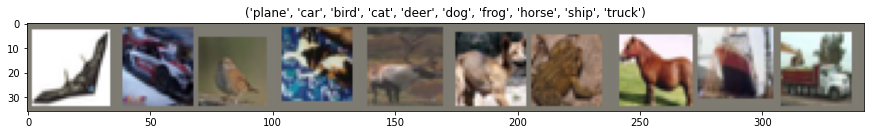

In [2]:
data = DataEngine(args)
data.show_samples()

In [3]:
device = which_device()
model = ResNet18(num_classes=200).to(device)
show_model_summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc >= 90.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

In [6]:
epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(data.train_loader),
                       epochs=epochs, div_factor=10, final_div_factor=10,
                       pct_start=10/epochs)

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, False)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.002000)


L2_loss=466.000 L1_loss=111599.398 Loss=2.01568 Batch_id=97 Accuracy=33.02: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.4189, Accuracy: 4774/10000 (47.74%)

EPOCH: 2 (LR: 0.002441)


L2_loss=466.091 L1_loss=111512.289 Loss=1.56138 Batch_id=97 Accuracy=53.25: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.1050, Accuracy: 6047/10000 (60.47%)

EPOCH: 3 (LR: 0.003722)


L2_loss=466.279 L1_loss=111420.977 Loss=1.50093 Batch_id=97 Accuracy=63.06: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.2095, Accuracy: 5877/10000 (58.77%)

EPOCH: 4 (LR: 0.005717)


L2_loss=466.528 L1_loss=111323.484 Loss=1.31568 Batch_id=97 Accuracy=69.64: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8431, Accuracy: 7033/10000 (70.33%)

EPOCH: 5 (LR: 0.008230)


L2_loss=466.784 L1_loss=111217.594 Loss=1.13260 Batch_id=97 Accuracy=75.46: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7420, Accuracy: 7428/10000 (74.28%)

EPOCH: 6 (LR: 0.011014)


L2_loss=467.035 L1_loss=111103.023 Loss=1.16335 Batch_id=97 Accuracy=78.30: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7326, Accuracy: 7568/10000 (75.68%)

EPOCH: 7 (LR: 0.013798)


L2_loss=467.236 L1_loss=110972.273 Loss=1.02886 Batch_id=97 Accuracy=80.91: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6702, Accuracy: 7759/10000 (77.59%)

EPOCH: 8 (LR: 0.016306)


L2_loss=467.418 L1_loss=110826.133 Loss=0.95228 Batch_id=97 Accuracy=82.69: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6842, Accuracy: 7802/10000 (78.02%)

EPOCH: 9 (LR: 0.018295)


L2_loss=467.561 L1_loss=110676.070 Loss=0.92583 Batch_id=97 Accuracy=84.63: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5910, Accuracy: 8031/10000 (80.31%)

EPOCH: 10 (LR: 0.019568)


L2_loss=467.687 L1_loss=110518.094 Loss=0.93212 Batch_id=97 Accuracy=86.00: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7300, Accuracy: 7571/10000 (75.71%)

EPOCH: 11 (LR: 0.020000)


L2_loss=467.772 L1_loss=110356.742 Loss=0.77289 Batch_id=97 Accuracy=87.00: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6214, Accuracy: 8070/10000 (80.70%)

EPOCH: 12 (LR: 0.019876)


L2_loss=467.854 L1_loss=110194.836 Loss=0.80049 Batch_id=97 Accuracy=87.93: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4737, Accuracy: 8405/10000 (84.05%)

EPOCH: 13 (LR: 0.019511)


L2_loss=467.909 L1_loss=110029.719 Loss=0.86221 Batch_id=97 Accuracy=88.78: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6662, Accuracy: 7925/10000 (79.25%)

EPOCH: 14 (LR: 0.018914)


L2_loss=467.925 L1_loss=109860.195 Loss=0.83594 Batch_id=97 Accuracy=89.87: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4960, Accuracy: 8417/10000 (84.17%)

EPOCH: 15 (LR: 0.018100)


L2_loss=467.940 L1_loss=109696.133 Loss=0.73481 Batch_id=97 Accuracy=90.40: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5187, Accuracy: 8342/10000 (83.42%)

EPOCH: 16 (LR: 0.017089)


L2_loss=467.909 L1_loss=109522.883 Loss=0.69441 Batch_id=97 Accuracy=91.45: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7651, Accuracy: 8032/10000 (80.32%)

EPOCH: 17 (LR: 0.015906)


L2_loss=467.874 L1_loss=109353.234 Loss=0.70976 Batch_id=97 Accuracy=92.06: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5662, Accuracy: 8255/10000 (82.55%)

EPOCH: 18 (LR: 0.014580)


L2_loss=467.828 L1_loss=109189.984 Loss=0.70037 Batch_id=97 Accuracy=92.43: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4776, Accuracy: 8495/10000 (84.95%)

EPOCH: 19 (LR: 0.013144)


L2_loss=467.754 L1_loss=109025.867 Loss=0.66675 Batch_id=97 Accuracy=93.17: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5693, Accuracy: 8318/10000 (83.18%)

EPOCH: 20 (LR: 0.011633)


L2_loss=467.650 L1_loss=108860.352 Loss=0.72105 Batch_id=97 Accuracy=93.84: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4815, Accuracy: 8570/10000 (85.70%)

EPOCH: 21 (LR: 0.010084)


L2_loss=467.509 L1_loss=108693.742 Loss=0.65174 Batch_id=97 Accuracy=94.55: 100%|██████████| 98/98 [01:00<00:00,  1.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4646, Accuracy: 8679/10000 (86.79%)

EPOCH: 22 (LR: 0.008536)


L2_loss=467.360 L1_loss=108534.727 Loss=0.64065 Batch_id=97 Accuracy=95.10: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3984, Accuracy: 8856/10000 (88.56%)

EPOCH: 23 (LR: 0.007026)


L2_loss=467.201 L1_loss=108385.734 Loss=0.61485 Batch_id=97 Accuracy=95.70: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4252, Accuracy: 8746/10000 (87.46%)

EPOCH: 24 (LR: 0.005591)


L2_loss=467.035 L1_loss=108249.391 Loss=0.63571 Batch_id=97 Accuracy=96.32: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 66 %
Accuracy of  bird : 80 %
Accuracy of   cat : 80 %
Accuracy of  deer : 100 %
Accuracy of   dog : 85 %
Accuracy of  frog : 75 %
Accuracy of horse : 87 %
Accuracy of  ship : 88 %
Accuracy of truck : 77 %

Test set: Average loss: 0.3375, Accuracy: 9013/10000 (90.13%)

EPOCH: 25 (LR: 0.004268)


L2_loss=466.872 L1_loss=108129.898 Loss=0.65536 Batch_id=97 Accuracy=96.97: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 75 %
Accuracy of   car : 100 %
Accuracy of  bird : 66 %
Accuracy of   cat : 80 %
Accuracy of  deer : 87 %
Accuracy of   dog : 88 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 87 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3297, Accuracy: 9027/10000 (90.27%)

EPOCH: 26 (LR: 0.003088)


L2_loss=466.731 L1_loss=108032.664 Loss=0.58334 Batch_id=97 Accuracy=97.40: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 90 %
Accuracy of  bird : 83 %
Accuracy of   cat : 87 %
Accuracy of  deer : 100 %
Accuracy of   dog : 58 %
Accuracy of  frog : 75 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 90 %

Test set: Average loss: 0.3394, Accuracy: 9040/10000 (90.40%)

EPOCH: 27 (LR: 0.002081)


L2_loss=466.623 L1_loss=107960.562 Loss=0.55139 Batch_id=97 Accuracy=97.91: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 50 %
Accuracy of  deer : 88 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 91 %
Accuracy of  ship : 100 %
Accuracy of truck : 77 %

Test set: Average loss: 0.3249, Accuracy: 9092/10000 (90.92%)

EPOCH: 28 (LR: 0.001272)


L2_loss=466.549 L1_loss=107913.883 Loss=0.53494 Batch_id=97 Accuracy=98.39: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 85 %
Accuracy of  bird : 100 %
Accuracy of   cat : 100 %
Accuracy of  deer : 100 %
Accuracy of   dog : 100 %
Accuracy of  frog : 75 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3168, Accuracy: 9102/10000 (91.02%)

EPOCH: 29 (LR: 0.000680)


L2_loss=466.509 L1_loss=107888.500 Loss=0.54425 Batch_id=97 Accuracy=98.62: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 100 %
Accuracy of  deer : 83 %
Accuracy of   dog : 66 %
Accuracy of  frog : 66 %
Accuracy of horse : 88 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3183, Accuracy: 9116/10000 (91.16%)

EPOCH: 30 (LR: 0.000319)


L2_loss=466.487 L1_loss=107875.289 Loss=0.54633 Batch_id=97 Accuracy=98.64: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Accuracy of plane : 100 %
Accuracy of   car : 88 %
Accuracy of  bird : 85 %
Accuracy of   cat : 88 %
Accuracy of  deer : 80 %
Accuracy of   dog : 90 %
Accuracy of  frog : 72 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3174, Accuracy: 9117/10000 (91.17%)



In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1,
                              verbose=True, min_lr=1e-5)

misclassified_imgs, correct_imgs = [], []
epochs = 10
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1+30} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 31 (LR: 0.000500)


L2_loss=466.403 L1_loss=107822.797 Loss=0.54307 Batch_id=97 Accuracy=98.69: 100%|██████████| 98/98 [01:00<00:00,  1.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 88 %
Accuracy of  deer : 80 %
Accuracy of   dog : 60 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3158, Accuracy: 9113/10000 (91.13%)

EPOCH: 32 (LR: 0.000500)


L2_loss=466.381 L1_loss=107809.070 Loss=0.52827 Batch_id=97 Accuracy=98.80: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 71 %
Accuracy of   car : 60 %
Accuracy of  bird : 100 %
Accuracy of   cat : 90 %
Accuracy of  deer : 91 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3213, Accuracy: 9115/10000 (91.15%)

EPOCH: 33 (LR: 0.000500)


L2_loss=466.358 L1_loss=107795.250 Loss=0.53298 Batch_id=97 Accuracy=98.85: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 100 %
Accuracy of  deer : 88 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 90 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3228, Accuracy: 9124/10000 (91.24%)

Epoch     3: reducing learning rate of group 0 to 2.5000e-04.
EPOCH: 34 (LR: 0.000250)


L2_loss=466.347 L1_loss=107788.258 Loss=0.52729 Batch_id=97 Accuracy=98.90: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 92 %
Accuracy of   cat : 91 %
Accuracy of  deer : 90 %
Accuracy of   dog : 71 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3195, Accuracy: 9126/10000 (91.26%)

EPOCH: 35 (LR: 0.000250)


L2_loss=466.336 L1_loss=107781.375 Loss=0.53407 Batch_id=97 Accuracy=98.92: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 77 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 66 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3207, Accuracy: 9119/10000 (91.19%)

Epoch     5: reducing learning rate of group 0 to 1.2500e-04.
EPOCH: 36 (LR: 0.000125)


L2_loss=466.330 L1_loss=107777.875 Loss=0.51372 Batch_id=97 Accuracy=98.95: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 90 %
Accuracy of  bird : 100 %
Accuracy of   cat : 100 %
Accuracy of  deer : 100 %
Accuracy of   dog : 77 %
Accuracy of  frog : 50 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3208, Accuracy: 9117/10000 (91.17%)

EPOCH: 37 (LR: 0.000125)


L2_loss=466.324 L1_loss=107774.406 Loss=0.54534 Batch_id=97 Accuracy=98.98: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 33 %
Accuracy of  deer : 100 %
Accuracy of   dog : 72 %
Accuracy of  frog : 66 %
Accuracy of horse : 87 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3188, Accuracy: 9123/10000 (91.23%)

Epoch     7: reducing learning rate of group 0 to 6.2500e-05.
EPOCH: 38 (LR: 0.000063)


L2_loss=466.321 L1_loss=107772.625 Loss=0.54219 Batch_id=97 Accuracy=98.89: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 75 %
Accuracy of   car : 80 %
Accuracy of  bird : 90 %
Accuracy of   cat : 87 %
Accuracy of  deer : 87 %
Accuracy of   dog : 92 %
Accuracy of  frog : 85 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3229, Accuracy: 9112/10000 (91.12%)

EPOCH: 39 (LR: 0.000063)


L2_loss=466.318 L1_loss=107770.906 Loss=0.53479 Batch_id=97 Accuracy=99.00: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 62 %
Accuracy of   cat : 90 %
Accuracy of  deer : 100 %
Accuracy of   dog : 80 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %

Test set: Average loss: 0.3222, Accuracy: 9116/10000 (91.16%)

Epoch     9: reducing learning rate of group 0 to 3.1250e-05.
EPOCH: 40 (LR: 0.000031)


L2_loss=466.317 L1_loss=107770.039 Loss=0.52614 Batch_id=97 Accuracy=98.87: 100%|██████████| 98/98 [00:59<00:00,  1.63it/s]



Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 75 %
Accuracy of  deer : 90 %
Accuracy of   dog : 72 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 88 %

Test set: Average loss: 0.3207, Accuracy: 9112/10000 (91.12%)



In [9]:
print('Device set to ', device)

Device set to  cuda


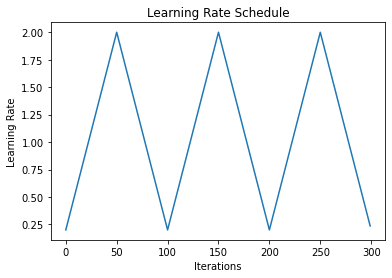

<Figure size 432x288 with 0 Axes>

In [11]:
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

Let us show some of the training images, for fun.



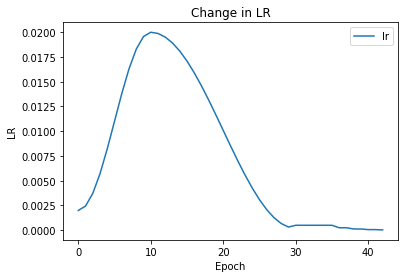

In [12]:
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

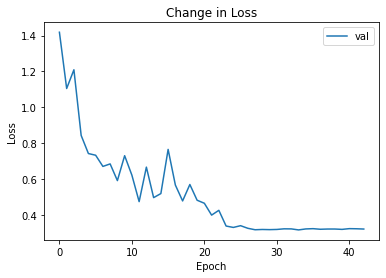

In [13]:
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

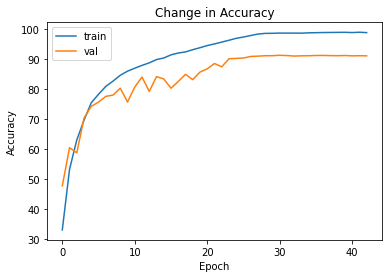

In [14]:
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [15]:

target_layers = ["layer0", "layer1", "layer2", "layer3"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

In [19]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)

RuntimeError: ignored